# preparer l'environnement

### import des biblio

In [1]:
import pickle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### definir les variables global

In [2]:
DATA_PATH = "./cifar-10-batches-py/"
data_augmentation = False
modelName = "resNet"

### la fonction pour chager des fichiers

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### la fonction pour visualisation des data

In [4]:
def show_first_samples(x_train, y_train, labels_name):
    
    for i in range(4):
        imgs = x_train[i]
        img0 = imgs[0]
        img1 = imgs[1]
        img2 = imgs[2]
        i0 = Image.fromarray(img0)
        i1 = Image.fromarray(img1)
        i2 = Image.fromarray(img2)
        img = Image.merge("RGB",(i0,i1,i2))
        plt.imshow(img)
        print(labels_name[y_train[i]])
        plt.show()

### la fonction pour chager des data

In [5]:
def load_data():
    data_first = unpickle(DATA_PATH + "data_batch_1")
    data_x = data_first[b'data']
    data_y = data_first[b'labels']
    for i in range(2,6):
        data = unpickle(DATA_PATH + f"data_batch_{i}")
        data_x = np.vstack((data_x, data[b'data']))
        data_y += data[b'labels']
    return data_x, data_y

# Creation de model

In [6]:
def create_model(depth: int = 4, use_skip_connections: bool = True):
    input_layer = Input((3072,))

    penultimate_output = None
    last_output = input_layer

    for i in range(depth):
        if penultimate_output is not None and use_skip_connections:
            add_output = Add(name=f"Add_{i}")([last_output, penultimate_output])
            add_output = Dropout(0.25)(add_output)
            penultimate_output = add_output
            last_output = Dense(3072, activation=linear, name=f"Dense_{i}")(
                add_output)
            # last_output = BatchNormalization()(last_output)
            last_output = Activation(activation=relu, name=f"Activation_{i}")(last_output)
        else:
            penultimate_output = last_output
            last_output = Dense(3072, activation=linear, name=f"Dense_{i}")(
                last_output)
            # last_output = BatchNormalization()(last_output)
            last_output = Activation(activation=relu, name=f"Activation_{i}")(last_output)
            

    if use_skip_connections:
        last_output = Add(name=f"Add_output")([last_output, penultimate_output])
        last_output = Dropout(0.25)(last_output)

    output_tensor = Dense(10, activation=softmax, name=f"Dense_output")(
        last_output)
    model = Model(input_layer, output_tensor)

    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model

# Preparation des data

### chargement des data et visualisation des data

b'frog'


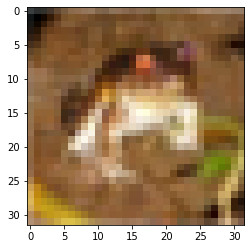

b'truck'


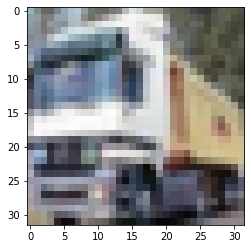

b'truck'


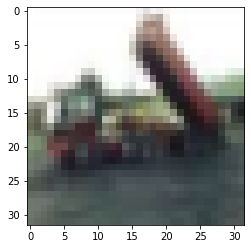

b'deer'


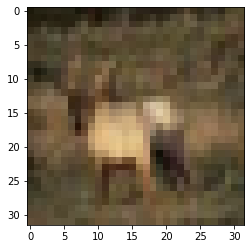

In [7]:
x_train, y_train = load_data() #load the train data cifar

data_test = unpickle(DATA_PATH + "test_batch") # load the test data
x_val, y_val = data_test[b'data'], data_test[b'labels'] 

data_info = unpickle(DATA_PATH + "batches.meta") #load the data infos
labels_name = data_info[b'label_names']

x_image = x_train.reshape(-1, 3, 32, 32)

y_train = np.array(y_train)
y_val = np.array(y_val)

show_first_samples(x_image, y_train, labels_name)

x_train = x_train / 255.0
x_val = x_val / 255.0

# Visualisation du model

### la resume du model

In [8]:
model = create_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3072)]       0                                            
__________________________________________________________________________________________________
Dense_0 (Dense)                 (None, 3072)         9440256     input_1[0][0]                    
__________________________________________________________________________________________________
Activation_0 (Activation)       (None, 3072)         0           Dense_0[0][0]                    
__________________________________________________________________________________________________
Add_1 (Add)                     (None, 3072)         0           Activation_0[0][0]               
                                                                 input_1[0][0]                

### tracer l'image de structure

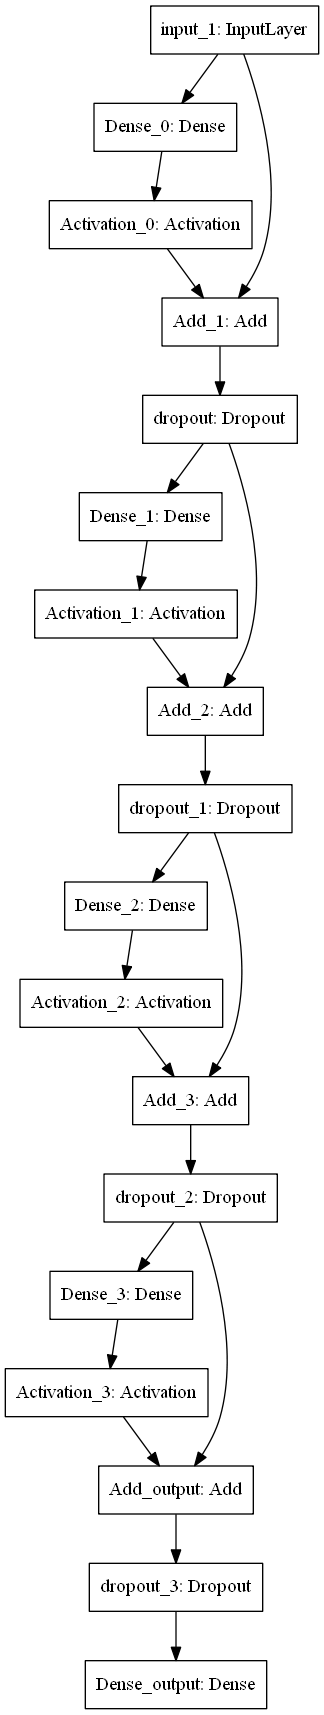

In [9]:
plot_model(model, f"{modelName}_log/{modelName}.png")

# Compile le model

### callbacks fonction : 
#### EarlyStopping : si val_accuracy n'ai pas augmenter deplus 2 epoch, la processus va arreter.
#### TensorBoard : une utils pour enregistrer les log

In [10]:
if data_augmentation:
    aug = ImageDataGenerator(width_shift_range = 0.2, height_shift_range = 0.2, horizontal_flip = True)
    aug.fit(x_train)
    gen = aug.flow(x_train, y_train, batch_size=128)
    history = model.fit_generator(generator=gen, 
                            steps_per_epoch=50000/128, 
                            epochs=30, 
                            validation_data=(x_val, y_val),
                            callbacks=[
                                EarlyStopping(monitor="val_accuracy", patience=2),
                                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                                ])
else:
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            epochs=30,
            batch_size=128,
            callbacks=[
                EarlyStopping(monitor="val_accuracy", patience=2),
                TensorBoard(log_dir=f"{modelName}_log", histogram_freq=1)
                ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 41s 826us/sample - loss: 4.3555 - accuracy: 0.2049 - val_loss: 1.8933 - val_accuracy: 0.3201loss: 4.9126 - accuracy:  - ETA: 7s - - ETA - ETA: 2s - los - ETA: 0s - loss: 4.3983 - accura - ETA: 0s - loss: 4.3700 - accuracy: 
Epoch 2/30
50000/50000 [==============================] - 49s 983us/sample - loss: 2.1279 - accuracy: 0.2726 - val_loss: 1.7741 - val_accuracy: 0.3759
Epoch 3/30
50000/50000 [==============================] - 49s 975us/sample - loss: 2.0173 - accuracy: 0.2962 - val_loss: 1.7430 - val_accuracy: 0.3809
Epoch 4/30
50000/50000 [==============================] - 46s 925us/sample - loss: 1.9540 - accuracy: 0.3131 - val_loss: 1.6918 - val_accuracy: 0.4052
Epoch 5/30
50000/50000 [==============================] - 46s 927us/sample - loss: 1.9092 - accuracy: 0.3277 - val_loss: 1.6786 - val_accuracy: 0.4021
Epoch 6/30
50000/50000 [==============================] - 46s 92

# Visualisation des resultat

### visualisation de accuracy

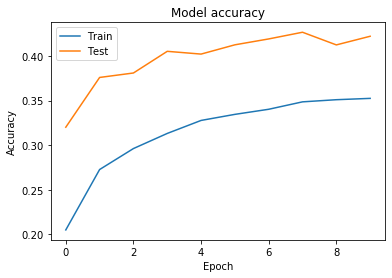

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_accuracy.png')
plt.show()

### visualisation de loss

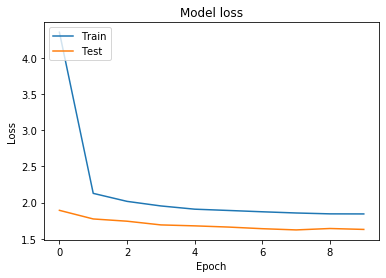

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(f'./{modelName}_log/{modelName}_loss.png')
plt.show()